In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Heat exchange simulation

### Euler's method

In [2]:
def heat_exchange_simulation(tb, tw, mb, mw, cb, cw, k, a, dt, improved=True):
    """
    Args:
        tb (float) - initial temperature of the bar
        tw (float) - initial temperature of the water
        mb (float) - mass of the bar
        mw (float) - mass of the water
        cb (float) - specific heat capacity of the bar
        cw (float) - specific heat capacity of the water
        k  (float | callable) - thermal conductivity, can be a callable that accepts temp delta and returns k 
        a  (float) - area of contact between the bodies
        dt (float) - time step of simulation
        improved (bool) - whether improved eulers method will be used
    Yields:
        (simulation time, bar temperature, water temperature)
    """
    h = k if callable(k) else (lambda dT: k)
    
    x = 0.0
    y = np.array([tb, tw])
    m = np.array([mb, mw])
    c = np.array([cb, cw])
    
    dy = lambda y: h(np.diff(y)) * a / m / c * np.diff(y) * np.array([1, -1])
    
    while True:
        yield x, *y
        x += dt
        
        if improved:
            yp = y + dt/2 * dy(y)
            y += dt * dy(yp)
        else:
            y += dt * dy(y)

### Simulation utils

In [3]:
def tabularize_symulation(sim, steps, round_time=None):
    data = itertools.islice(sim, steps)
    df = pd.DataFrame.from_records(data, columns=['t', 'Tbt', 'Twt'])
    
    if round_time is not None:
        df['t'] = df['t'].round(round_time)
    
    return df

### Manual test

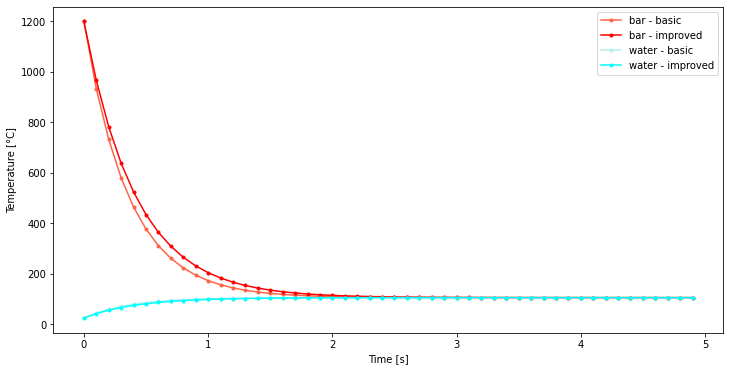

In [4]:
SIM_TIME = 5.0
TIME_STEP = 0.1
SETTINGS = dict(tb=1200.0, tw=25.0, mb=0.2, mw=2.5, cb=3.85, cw=4.1813, k=160, a=0.0109, dt=TIME_STEP)

# setup simulation
sim_basic = heat_exchange_simulation(**SETTINGS, improved=False)
sim_improved = heat_exchange_simulation(**SETTINGS, improved=True)

# tabularize simulation
steps = int(SIM_TIME / TIME_STEP)
sim_basic = tabularize_symulation(sim_basic, steps)
sim_improved = tabularize_symulation(sim_improved, steps)

# plot
plt.figure(figsize=(12,6))
plt.plot(sim_basic['t'], sim_basic['Tbt'], color='tomato', marker='o', markersize=3, label='bar - basic')
plt.plot(sim_improved['t'], sim_improved['Tbt'], color='red', marker='o', markersize=3, label='bar - improved')
plt.plot(sim_basic['t'], sim_basic['Twt'], color='paleturquoise', marker='o', markersize=3, label='water - basic')
plt.plot(sim_improved['t'], sim_improved['Twt'], color='cyan', marker='o', markersize=3, label='water - improved')
plt.legend(loc='upper right')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]');

### Ground truth test

In [5]:
ground_truth = pd.read_csv('data/ground-truth.csv', index_col=0).astype(float)

In [6]:
ground_truth

,tb,tw,mb,mw,cb,cw,k,a,t,Tbt,Twt
2,800.0,25.0,0.2,2.5,3.85,4.1813,160.0,0.0109,3.0,79.1,78.0
5,800.0,25.0,0.2,2.5,3.85,4.1813,160.0,0.0109,5.0,78.2,78.1
6,1100.0,70.0,0.2,2.5,3.85,4.1813,160.0,0.0109,2.0,150.1,138.2
3,1100.0,70.0,0.2,2.5,3.85,4.1813,160.0,0.0109,3.0,142.1,139.1
9,1100.0,70.0,0.2,2.5,3.85,4.1813,160.0,0.0109,4.0,141.2,139.8
10,1100.0,70.0,0.2,2.5,3.85,4.1813,160.0,0.0109,5.0,140.9,140.1
7,1100.0,70.0,0.2,5.0,3.85,4.1813,160.0,0.0109,2.0,116.6,105.1
8,1100.0,70.0,0.2,10.0,3.85,4.1813,160.0,0.0109,2.0,99.1,88.1
1,1200.0,25.0,0.2,2.5,3.85,4.1813,160.0,0.0109,3.0,107.7,105.1
4,1200.0,25.0,0.2,2.5,3.85,4.1813,160.0,0.0109,5.0,105.7,105.5


In [7]:
TIME_STEP = 0.1

results = ground_truth[['Tbt', 'Twt']].add_suffix('_gt')
results['Tbt_basic'] = None
results['Twt_basic'] = None
results['Tbt_improved'] = None
results['Twt_improved'] = None

# gather simulation results
for index, row in ground_truth.iterrows():
    settings = row[:-3].to_dict()
    
    # setup simulations
    sim_basic = heat_exchange_simulation(**settings, dt=TIME_STEP, improved=False)
    sim_improved = heat_exchange_simulation(**settings, dt=TIME_STEP, improved=True)
    
    # simulate
    basic_result = next(itertools.islice(sim_basic, int(row['t'] / TIME_STEP), None))
    improved_result = next(itertools.islice(sim_improved, int(row['t'] / TIME_STEP), None))
    
    # save results
    results.at[index, ['Tbt_basic', 'Twt_basic']] = basic_result[1:]
    results.at[index, ['Tbt_improved', 'Twt_improved']] = improved_result[1:]

# calcualte errors
results['Tbt_basic_error'] = (results['Tbt_basic'] - results['Tbt_gt']).abs() / results['Tbt_gt']
results['Tbt_improved_error'] = (results['Tbt_improved'] - results['Tbt_gt']).abs() / results['Tbt_gt']
results['Twt_basic_error'] = (results['Twt_basic'] - results['Twt_gt']).abs() / results['Twt_gt']
results['Twt_improved_error'] = (results['Twt_improved'] - results['Twt_gt']).abs() / results['Twt_gt']

results

,Tbt_gt,Twt_gt,Tbt_basic,Twt_basic,Tbt_improved,Twt_improved,Tbt_basic_error,Tbt_improved_error,Twt_basic_error,Twt_improved_error
2,79.1,78.0,78.34,78.1584,78.7049,78.1315,0.00960787,0.0049947,0.00203094,0.00168634
5,78.2,78.1,78.1715,78.1708,78.1752,78.1706,0.000364247,0.000316604,0.000906858,0.000903344
6,150.1,138.2,144.312,140.397,148.513,140.088,0.0385602,0.0105707,0.0158988,0.0136595
3,142.1,139.1,140.891,140.649,141.376,140.614,0.00851088,0.00509803,0.0111376,0.0108808
9,141.2,139.8,140.68,140.665,140.73,140.661,0.0036851,0.00332862,0.00618587,0.00615935
10,140.9,140.1,140.667,140.666,140.672,140.665,0.00165607,0.00162093,0.00403813,0.00403553
7,116.6,105.1,111.289,106.415,116.132,106.237,0.0455454,0.00401417,0.0125105,0.0108135
8,99.1,88.1,93.961,88.5265,99.1566,88.4309,0.0518572,0.000571394,0.0048415,0.00375546
1,107.7,105.1,105.87,105.595,106.424,105.554,0.0169884,0.0118516,0.00470993,0.00432219
4,105.7,105.5,105.615,105.614,105.621,105.613,0.000805309,0.000751868,0.00107898,0.00107504


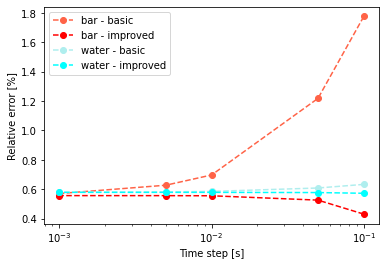

In [8]:
TIME_STEPS = [0.1, 0.05, 0.01, 0.005, 0.001]

results = pd.DataFrame(index=TIME_STEPS)
results[['Tbt_basic_error', 'Tbt_improved_error', 'Twt_basic_error', 'Twt_improved_error']] = None

for time_step in TIME_STEPS:
    
    tbt_basic_errors = []
    tbt_improved_errors = []
    twt_basic_errors = []
    twt_improved_errors = []
    
    for index, row in ground_truth.iterrows():
        settings = row[:-3].to_dict()
        
        # setup simulations
        sim_basic = heat_exchange_simulation(**settings, dt=time_step, improved=False)
        sim_improved = heat_exchange_simulation(**settings, dt=time_step, improved=True)
    
        # simulate
        basic_result = next(itertools.islice(sim_basic, int(row['t'] / time_step), None))
        improved_result = next(itertools.islice(sim_improved, int(row['t'] / time_step), None))
        
        tbt_basic_errors.append(abs(basic_result[1] - row['Tbt']) / row['Tbt'])
        tbt_improved_errors.append(abs(improved_result[1] - row['Tbt']) / row['Tbt'])
        twt_basic_errors.append(abs(basic_result[2] - row['Twt']) / row['Twt'])
        twt_improved_errors.append(abs(improved_result[2] - row['Twt']) / row['Twt'])
    
    results.at[time_step, 'Tbt_basic_error'] = np.mean(tbt_basic_errors)    
    results.at[time_step, 'Tbt_improved_error'] = np.mean(tbt_improved_errors)
    results.at[time_step, 'Twt_basic_error'] = np.mean(twt_basic_errors)
    results.at[time_step, 'Twt_improved_error'] = np.mean(twt_improved_errors)

plt.plot(results.index, results['Tbt_basic_error'] * 100, 'o--', c='tomato', label='bar - basic')
plt.plot(results.index, results['Tbt_improved_error'] * 100, 'o--', c='red', label='bar - improved')
plt.plot(results.index, results['Twt_basic_error'] * 100, 'o--', c='paleturquoise', label='water - basic')
plt.plot(results.index, results['Twt_improved_error'] * 100, 'o--', c='cyan', label='water - improved')
plt.legend(loc='upper left')
plt.ylabel('Relative error [%]')
plt.xlabel('Time step [s]')
plt.xscale('log')
# plt.yscale('log')

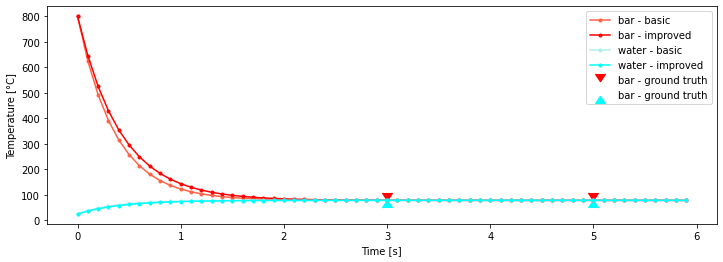

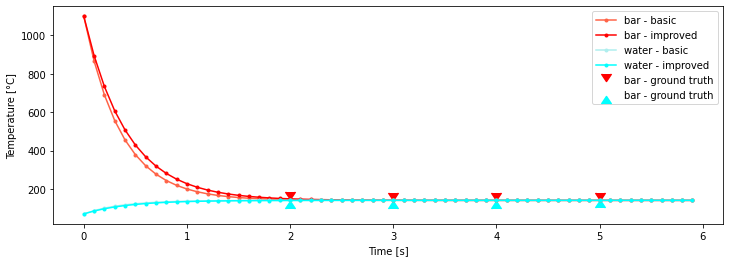

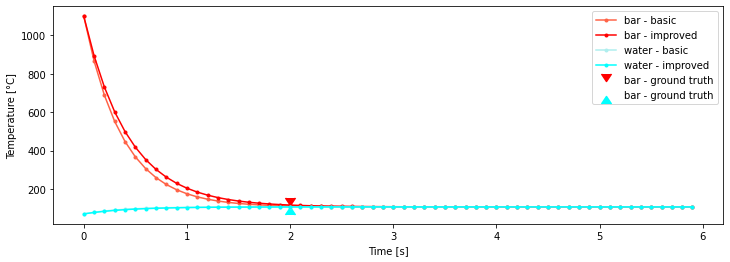

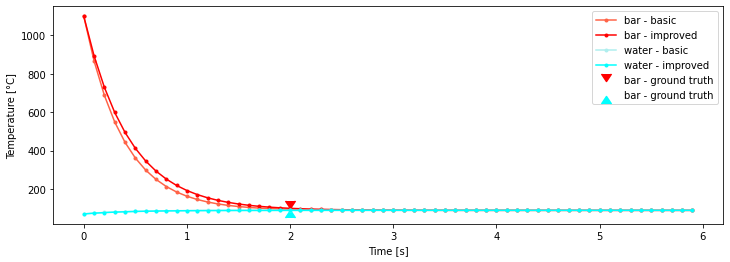

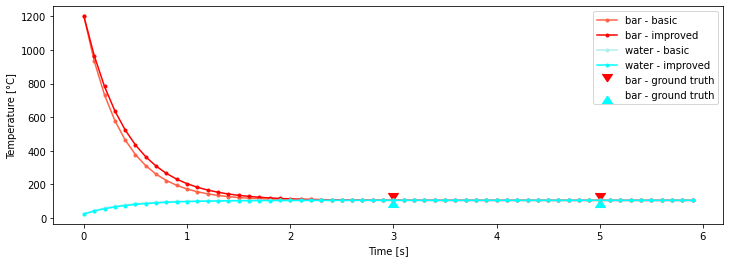

In [9]:
SIM_TIME = 6.0
TIME_STEP = 0.1

steps = int(SIM_TIME / TIME_STEP)

# group ground truth into experiments
settings_columns = list(ground_truth.columns[:-3])
experiments = ground_truth.groupby(settings_columns)

# for each experiment
for settings_values, gt in experiments:
    settings = dict(zip(settings_columns, settings_values))
    
    # setup simulation
    sim_basic = heat_exchange_simulation(**settings, dt=TIME_STEP, improved=False)
    sim_improved = heat_exchange_simulation(**settings, dt=TIME_STEP, improved=True)

    # tabularize simulation
    sim_basic = tabularize_symulation(sim_basic, steps)
    sim_improved = tabularize_symulation(sim_improved, steps)
    
    # plot
    plt.figure(figsize=(12,4))
    plt.plot(sim_basic['t'], sim_basic['Tbt'], color='tomato', marker='o', markersize=3, label='bar - basic')
    plt.plot(sim_improved['t'], sim_improved['Tbt'], color='red', marker='o', markersize=3, label='bar - improved')
    plt.scatter(gt['t'], gt['Tbt'], c='red', marker=7, s=100, label='bar - ground truth')
    plt.plot(sim_basic['t'], sim_basic['Twt'], color='paleturquoise', marker='o', markersize=3, label='water - basic')
    plt.plot(sim_improved['t'], sim_improved['Twt'], color='cyan', marker='o', markersize=3, label='water - improved')
    plt.scatter(gt['t'], gt['Twt'], c='cyan', marker=6, s=100, label='bar - ground truth')
    plt.legend(loc='upper right')
    plt.xlabel('Time [s]')
    plt.ylabel('Temperature [°C]')
    plt.show()

## Part 2 - Approximation and interpolation

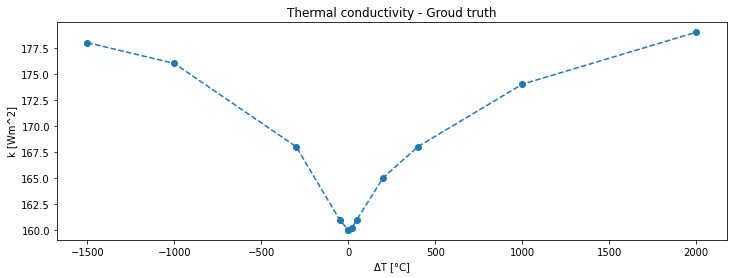

In [10]:
conductivity_data = pd.read_csv('data/conductivity.csv', index_col=0).astype(float)

plt.figure(figsize=(12,4))
plt.plot(conductivity_data.index, conductivity_data['k'], 'o--')
plt.xlabel('ΔT [°C]')
plt.ylabel('k [Wm^2]')
plt.title('Thermal conductivity - Groud truth');

### Tabularization

In [11]:
def linear_spline(xs, ys):
    def func(x):
        if not xs[0] <= x <= xs[-1]:
            return np.nan
        i = np.searchsorted(xs, x)
        return ys[i-1] + (ys[i] - ys[i-1]) / (xs[i] - xs[i-1]) * (x - xs[i-1])
#         return ys[i-1]
    return func

In [12]:
def tabularize_function(f, start, stop, samples):
    xs = np.linspace(start, stop, samples)
    ys = np.vectorize(f)(xs)
    return np.column_stack([xs, ys])

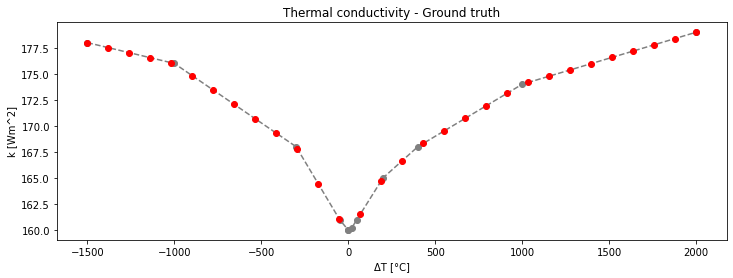

In [13]:
conductivity_norm_spline = linear_spline(conductivity_data.index.values, conductivity_data['k'].values)
conductivity_norm = tabularize_function(conductivity_norm_spline, -1500, 2000, 30)

plt.figure(figsize=(12,4))
plt.plot(conductivity_data.index, conductivity_data['k'], 'o--', c='grey')
plt.scatter(conductivity_norm[:,0], conductivity_norm[:,1], c='r', zorder=10)
plt.xlabel('ΔT [°C]')
plt.ylabel('k [Wm^2]')
plt.title('Thermal conductivity - Ground truth');

### Approximation error

In [14]:
def approximation_error(f, xs, ys):
    approx_ys = np.vectorize(f)(xs)
    return np.sqrt(((ys - approx_ys) ** 2).sum() / len(ys))

### Least squares polynomial approximation

In [15]:
def polynomial_approximation(xs, ys, degree):
    M = np.array([[x**d for d in range(degree+1)]for x in xs])
    Y = np.array(ys)
    A = np.linalg.inv((M.T).dot(M)).dot(M.T).dot(Y)
    
    return lambda x: (A * x ** np.arange(degree+1)).sum()

### Params searching

In [16]:
DEGREES = list(range(1, 21))
SAMPLES = ['original'] + list(range(5, 31, 5))

spline = linear_spline(conductivity_data.index.values, conductivity_data['k'].values)

errors = pd.DataFrame(
    data=itertools.product(DEGREES, SAMPLES),
    columns=['degree', 'samples'],
    dtype=int
)
errors['error'] = None

for index, row in errors.iterrows():
    if row['samples'] == 'original':
        approx = polynomial_approximation(conductivity_data.index.values, conductivity_data['k'].values, row['degree'])
    else:
        tabular = tabularize_function(spline, -1500, 2000, row['samples'])
        approx = polynomial_approximation(tabular[:,0], tabular[:,1], row['degree'])
    
    errors.at[index, 'error'] = approximation_error(approx, conductivity_data.index.values, conductivity_data['k'].values)


errors.sort_values('error').head(15)

,degree,samples,error
31,5,15,2.91137
30,5,10,2.95332
32,5,20,3.00989
33,5,25,3.04284
34,5,30,3.05454
24,4,15,3.45707
23,4,10,3.48693
25,4,20,3.52884
26,4,25,3.55479
27,4,30,3.56158


2.9113715297709604

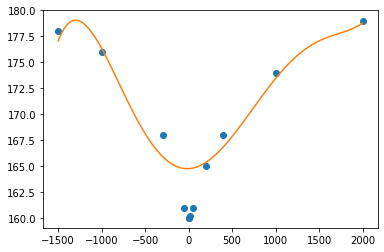

In [17]:
spline = linear_spline(conductivity_data.index.values, conductivity_data['k'].values)
tabular = tabularize_function(spline, -1500, 2000, 15)
approx = polynomial_approximation(tabular[:,0], tabular[:,1], 5)
data = tabularize_function(approx, -1500, 2000, 1000)

plt.plot(conductivity_data.index, conductivity_data['k'], 'o')
plt.plot(data[:,0], data[:,1]);
approximation_error(approx, conductivity_data.index.values, conductivity_data['k'].values)

3.6741508336541435

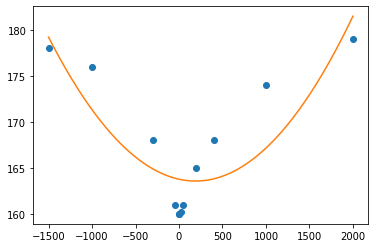

In [18]:
approx = polynomial_approximation(conductivity_data.index.values, conductivity_data['k'].values, 2)
data = tabularize_function(approx, -1500, 2000, 500)

plt.plot(conductivity_data.index, conductivity_data['k'], 'o')
plt.plot(data[:,0], data[:,1])
approximation_error(approx, conductivity_data.index.values, conductivity_data['k'].values)

### Spline interpolation

In [19]:
from splines import CubicSpline 
from utils import tabularize

3.6741508336541435

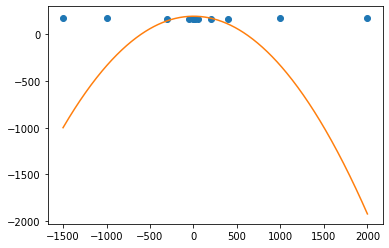

In [24]:
# samples = tabularize_function(linear_spline(conductivity_data.index.values, conductivity_data['k'].values), -1500, 2000, 10)
samples = np.array([conductivity_data.index.values, conductivity_data['k'].values])
spline = CubicSpline(samples)
data = tabularize(spline, -1500, 2000, 500)

plt.plot(conductivity_data.index, conductivity_data['k'], 'o')
plt.plot(data[:,0], data[:,1])
approximation_error(approx, conductivity_data.index.values, conductivity_data['k'].values)